In [1]:
# %load init.ipy
%reload_ext autoreload
%autoreload 2

# %load init.ipy
import os, sys, logging, datetime
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from nose import tools

import corner
import tqdm
import memory_profiler as mpro

import kalepy as kale
import kalepy.plot
from kalepy.plot import nbshow   # NOTE: this should be upgraded to `plot_control`

# NOTE: This is for when the notebook is converted to a python script
def get_ipython():
    return type('Dummy', (object,), dict(run_line_magic=lambda *args, **kwargs: None))

In [2]:
import re
import glob

In [3]:
_path = os.path.join(os.path.dirname(kale.__file__), os.path.pardir, 'docs', 'logo')
_path = os.path.abspath(_path)

PATH_INPUT = os.path.join(_path, 'data')
PATH_OUTPUT = os.path.join(_path, 'media')
    
print("Input : '{}'".format(PATH_INPUT))
print("Output: '{}'".format(PATH_OUTPUT))

Input : '/Users/lzkelley/Programs/kalepy/docs/logo/data'
Output: '/Users/lzkelley/Programs/kalepy/docs/logo/media'


In [4]:
def curve_lin(extr, num):
    yy = np.linspace(*extr, num)
    return yy
    
def curve_sig(extr, num, cut=[0.0, 1.0]):
    lo, hi = np.interp(cut, [0.0, 1.0], [-np.pi, np.pi])
    yy = np.tanh(np.linspace(lo, hi, num))
    yy -= yy.min()
    yy /= yy.max()/2
    yy -= 1
    print(kale.utils.minmax(yy))
#     wid = np.diff(kale.utils.minmax(yy))
#     yy = yy / (wid/2)
    yy = np.diff(extr)/2 * yy + np.mean(extr)
    return yy

def pad_ends(extr, num, func, pad):
    yy = func(extr, num)
    lo = [extr[0]] * pad[0]
    hi = [extr[1]] * pad[1]
    yy = np.concatenate([lo, yy, hi])
    return yy

def my_save_fig(fig, fname, **kwargs):
    return kale.utils.save_fig(fig, fname, path=PATH_OUTPUT, **kwargs)

## Load Data

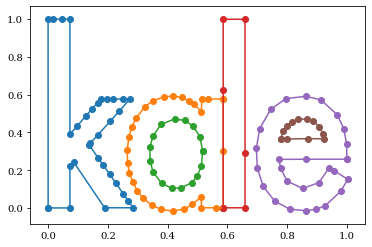

In [5]:
fnames = ['k', 'a1', 'a2', 'l', 'e1', 'e2']

xvals = []
yvals = []
for ff in fnames:
    fname = os.path.join(PATH_INPUT, ff + ".txt")
    xx, yy = np.loadtxt(fname, skiprows=1).T
    xx = np.append(xx, [xx[0]])
    yy = np.append(yy, [yy[0]])
    xvals.append(xx)
    yvals.append(yy)
    
    plt.scatter(xx, yy)
    plt.plot(xx, yy)    
    
nbshow()

## Draw Logo

In [6]:
def figax():
    fig, ax = plt.subplots(figsize=[6, 4])
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    return fig, ax


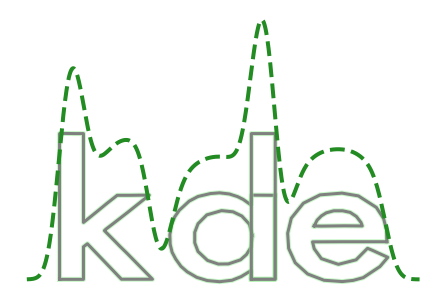

AttributeError: module 'kalepy.utils' has no attribute 'save_fig'

In [7]:
c1 = 'forestgreen'
c2 = 'darkgreen'
# colors = [c1, c2, c2, c1, c2, c2]
c3 = '0.5'
ckde = 'forestgreen'
colors = [c3, c3, c3, c3, c3, c3]


fig, ax = figax()

grid = np.linspace(-0.1, 1.1, 1000)

xnew = []
ynew = []

new_cuts = [
    np.arange(1, 15),
    [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 29, 30],
    [],
    [2, 3],
    [1, 2,  3,  4,  5,  6,  7,  8,  9],
    []
]

for ii, (xx, yy, cc) in enumerate(zip(xvals, yvals, colors)):
    if ii in [1, 2]:
        xx = xx + 0.072
    ax.plot(xx, yy, color='lightgreen', lw=5.0, alpha=0.5)
    ax.plot(xx, yy, color=cc, lw=3.0)
    
    if len(new_cuts[ii]) == 0:
        xnew.append([])
        ynew.append([])
        continue
        
    sel = new_cuts[ii]
    aa = xx[sel]
    bb = yy[sel]
    idx = np.argsort(aa)
    aa = aa[idx]
    bb = bb[idx]
    
    extr = kale.utils.minmax(aa)
    num = int(np.diff(extr)*100)
    xx = np.linspace(*extr, 100)
    yy = np.interp(xx, aa, bb)

    if ii == 3:
        yy = yy * 0.2
            
    xnew.append(xx)
    ynew.append(yy)
    
xx = np.concatenate(xnew)
yy = np.concatenate(ynew)
idx = np.argsort(xx)
xx = xx[idx]
yy = yy[idx]
kde = kale.KDE(xx, weights=yy, bw_rescale=0.3)
pdf = kde.pdf(grid)
ax.plot(grid, 0.9*pdf, color=ckde, ls='--', lw=4.0)

nbshow()
fname = 'test_anim_000.png'
my_save_fig(fig, fname, transparent=True)

## Animation

In [ ]:
c1 = 'forestgreen'
c2 = 'darkgreen'
# colors = [c1, c2, c2, c1, c2, c2]
c3 = '0.5'
ckde = 'forestgreen'
colors = [c3, c3, c3, c3, c3, c3]


def draw_shift(shift, fname, show=False, close=True):
    fig, ax = figax()

    grid = np.linspace(-0.1, 1.1, 1000)

    xnew = []
    ynew = []

    new_cuts = [
        np.arange(1, 15),
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 29, 30],
        [],
        [2, 3],
        [1, 2,  3,  4,  5,  6,  7,  8,  9],
        []
    ]

    for ii, (xx, yy, cc) in enumerate(zip(xvals, yvals, colors)):
        if ii in [1, 2]:
            xx = xx + 0.072 + shift
        ax.plot(xx, yy, color='lightgreen', lw=7.0, alpha=0.5)
        ax.plot(xx, yy, color=cc, lw=3.0)

        if len(new_cuts[ii]) == 0:
            xnew.append([])
            ynew.append([])
            continue

        sel = new_cuts[ii]
        aa = xx[sel]
        bb = yy[sel]
        idx = np.argsort(aa)
        aa = aa[idx]
        bb = bb[idx]

        extr = kale.utils.minmax(aa)
        num = int(np.diff(extr)*100)
        xx = np.linspace(*extr, 100)
        yy = np.interp(xx, aa, bb)

        if ii == 3:
            yy = yy * 0.2

        xnew.append(xx)
        ynew.append(yy)

    xx = np.concatenate(xnew)
    yy = np.concatenate(ynew)
    idx = np.argsort(xx)
    xx = xx[idx]
    yy = yy[idx]
    kde = kale.KDE(xx, weights=yy, bw_rescale=0.3)
    pdf = kde.pdf(grid)
    ax.plot(grid, 0.9*pdf, color=ckde, ls='--', lw=4.0)

    # ax.set_ylim(-0.10569756676491791, 1.867648902063276)

    
    fname = my_save_fig(fig, fname, transparent=False, quiet=True)
    if show:
        plt.show()
    if close:
        plt.close('all')

    return fname
    
EXTR = [-0.1, 0.0]
NUM = 86
PAD = [4, 10]

# RUN THIS CODE TO PRODUCE EACH IMAGE FOR THE ANIMATION
# --------------------------------------------------------------------------------

# fname = 'anim_sigmoid_02_08/test_anim_000.png'
# curve = pad_ends(EXTR, NUM, lambda *xx: curve_sig(*xx, cut=[0.2, 0.8]), PAD)
# saved_fnames = []
# for ii in tqdm.tqdm_notebook(curve):
#     fn = draw_shift(ii, fname)
#     saved_fnames.append(fn)

# print("Saved {} files, e.g. '{}'".format(len(saved_fnames), saved_fnames[0]))

# GIF_COMMAND = "convert -fuzz 2% -layers Optimize -delay 5 anim/*.png anim.gif"
# print("Combine into gif with: \n\t'{}'")

In [ ]:
draw_shift(0.0, 'logo.png', close=False, show=True)

In [ ]:
NUM = 40
EXTR = [-0.1, 0.0]

curves = [
    curve_lin,
    lambda *xx: curve_sig(*xx),
    lambda *xx: curve_sig(*xx, cut=[0.2, 0.8]),
    lambda *xx: curve_sig(*xx, cut=[0.3, 0.8]),
]


for ff in curves:
    # yy = ff(EXTR, NUM)
    yy = pad_ends(EXTR, NUM, ff, [4, 10])
    plt.plot(yy)

    
nbshow()